# Transfer Learning Hubble Image Similarity Processing

In [ ]:
import pickle
import os
import shutil

from transfer_learning.fingerprint.processing import FingerprintCalculatorResnet
from transfer_learning.fingerprint.processing import calculate as fingerprint_calculate
from transfer_learning.similarity.similarity import calculate as similarity_calculate
from transfer_learning.data import Data
from transfer_learning.cutout.processing import Resize as CutoutResize
from transfer_learning.cutout.processing import Crop as CutoutCrop
from transfer_learning.cutout.generators import FullImageCutoutGenerator
from transfer_learning.database import get_database

db = get_database('blitzdb', 'basic_notebook_20.db')

## Load the pre-massaged data

The pickle file contains a list of dictionaries. Each dictionary represents an image and contains info about the file location, RA/DEC and meta data (observation information).

For example:
```
{'location': 'http://18.218.192.161:4123/ACSimages/j6jt03020_drz_small.jpg',
 'meta': {'calib_level': 3,
  'dataRights': 'PUBLIC',
  'dataURL': 'mast:HST/product/j6jt03020_drz.fits',
  'dataproduct_type': 'image',
  'em_max': 7.08e-07,
  'em_min': 9.59e-07,
  'filters': 'F814W',
  'instrument_name': 'ACS/WFC',
  'intentType': 'science',
  'jpegURL': 'mast:HST/product/j6jt03020_drz.jpg',
  'mtFlag': False,
  'objID': '2000000046',
  'obs_collection': 'HST',
  'obs_id': 'j6jt03020',
  'obs_title': 'Massive Black Holes in Early Type Galaxies',
  'obsid': '2003859773',
  'project': 'HST',
  'proposal_id': '9293',
  'proposal_pi': 'Ford, Holland',
  'proposal_type': 'GTO/ACS',
  's_dec': -50.44308333333,
  's_ra': 113.484125,
  's_region': 'POLYGON 113.44645052 -50.42181811 113.4384584 -50.44956291 113.52376071 -50.46441676 113.53283592 -50.43611022 113.44645052 -50.42181811 113.44645052 -50.42181811',
  'srcDen': masked,
  't_exptime': 857.0448000216857,
  't_max': 52845.0091944,
  't_min': 52845.0191139,
  't_obs_release': 53211.01324,
  'target_classification': 'field',
  'target_name': 'ESO208-G21',
  'wavelength_region': 'Optical'},
 'radec': (113.484125, -50.44308333333)}
 ```

In [ ]:
# Load the data
processing_dict = pickle.load(open('../data/hubble_acs.pck', 'rb'))

## Save the Image Data

Each data element will be saved to a Data object in order to confirm input is correct and then save to a database for later retrival. An example image is: 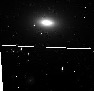

In [ ]:
data = []
for fileinfo in processing_dict[:20]:
    im = Data(location=fileinfo['location'], radec=fileinfo['radec'], meta=fileinfo['meta'])
    data.append(im)
    db.save('data', im)

## Create the Cutouts

Cutouts of the images will be made. The cutouts in this case represent a 224x224 cutout of the data and these cutouts will be stored in the database too. The cutouts could have other types of image processing applied to the underlying data.

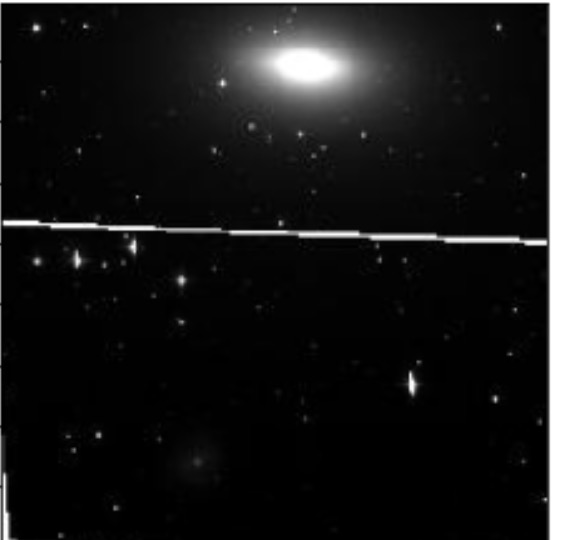

In [ ]:
full_cutout = FullImageCutoutGenerator(output_size=(224, 224))

cutout_crop = CutoutCrop([15, -15, 15, -15])
cutout_resize = CutoutResize([224, 224])

In [ ]:
cutouts = []
for datum in data:
    cutout = full_cutout.create_cutouts(datum)

    cutout.add_processing(cutout_crop)
    cutout.add_processing(cutout_resize)
    
    db.save('cutout', cutout)
    cutouts.append(cutout)

## Compute the Fingerprints

Compute the fingerprints from each of the cutouts based on, in this case, the Resnet50 pre-trained network.  The fingerprints are stored in the database too.  The Fingerprint calculator will calculate based on the [Resnet50](https://keras.io/applications/#resnet50), [VGG16](https://keras.io/applications/#vgg16), [VGG19](https://keras.io/applications/#vgg19), [InceptionV3](https://keras.io/applications/#inceptionv3) or [InceptionResnetV2](https://keras.io/applications/#inceptionresnetv2) pre-trained networks.  The fingerprints are computed using [Keras](https://keras.io) and [Google's Tensorflow backend](https://www.tensorflow.org).

The fingerprint will look something like:
```
[['n04286575', 'spotlight', 0.39021581411361694],
 ['n09229709', 'bubble', 0.1927020102739334],
 ['n02788148', 'bannister', 0.06545353680849075],
 ['n03388043', 'fountain', 0.04016595706343651],
 ['n03028079', 'church', 0.020774058997631073],
 ['n03976657', 'pole', 0.019223248586058617],
 ['n03196217', 'digital_clock', 0.018269173800945282],
 ['n04366367', 'suspension_bridge', 0.014173725619912148],
 ['n04589890', 'window_screen', 0.01129070296883583],
 ['n02793495', 'barn', 0.008158819749951363],
 ['n03857828', 'oscilloscope', 0.007918311282992363],
 ['n03874599', 'padlock', 0.007855708710849285],
 ['n04507155', 'umbrella', 0.00783586222678423],
 ['n03000134', 'chainlink_fence', 0.006827631965279579],
 ```

In [ ]:
# This will take a minute as it is loading the pre-trained network
fresnet = FingerprintCalculatorResnet()
fc_save = fresnet.save()

In [ ]:
fingerprints = fingerprint_calculate(cutouts, fc_save)
[db.save('fingerprint', x) for x in fingerprints]

## Compute the Similarity

Once the fingerprints are calculated, next the similarity is calculated. In this case the [tSNE algorithm](https://lvdmaaten.github.io/tsne/) is used which is a data reduction algorithm and enables determining similar cutouts given one cutout.  The tSNE similarity is represented by a 2D plot where each element is a fingerprint (and therefore represents a cutout of an image). For example:
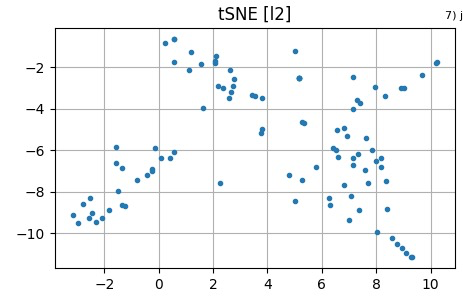

In [ ]:
similarity_tsne = similarity_calculate(fingerprints, 'tsne')
db.save('similarity', similarity_tsne)